In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import random
import cv2
import tempfile
from PIL import Image


print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [4]:

base_dir = './data'
sub_dirs = {
    'train': ['NORMAL', 'PNEUMONIA'],
    'test': ['NORMAL', 'PNEUMONIA'],
    'val': [] 
}

dir_paths = {}
temp_dir_base = tempfile.mkdtemp()


for dir_key, subfolders in sub_dirs.items():
    main_dir_path = os.path.join(base_dir, dir_key)
    if not os.path.exists(main_dir_path):
        raise FileNotFoundError(f'👺 {dir_key.capitalize()} directory does not exist')
    
    dir_paths[dir_key] = main_dir_path  

    for subfolder in subfolders:
        subfolder_path = os.path.join(main_dir_path, subfolder)
        if not os.path.exists(subfolder_path):
            raise FileNotFoundError(f'👺 {dir_key.capitalize()} {subfolder.lower()}  directory does not exist')
        
        dir_paths[f"{dir_key}_{subfolder.lower()}"] = subfolder_path
print('✅ Data directories are successfully loaded')

✅ Data directories are successfully loaded


In [5]:
def sample_count(direct,dirname):
    sub_dir = os.listdir(direct)
    for direc in sub_dir:
            classpath=os.path.join(direct, direc)
            filelist = os.listdir(classpath)
            print(f"Number of samples in {dirname} directory for {direc} is {len(filelist)}")  

sample_count(dir_paths['train'],"training")
sample_count(dir_paths['test'],"testing")
sample_count(dir_paths['val'],"validation")

Number of samples in training directory for NORMAL is 1341
Number of samples in training directory for PNEUMONIA is 3875
Number of samples in testing directory for NORMAL is 234
Number of samples in testing directory for PNEUMONIA is 390
Number of samples in validation directory for NORMAL is 9
Number of samples in validation directory for PNEUMONIA is 9


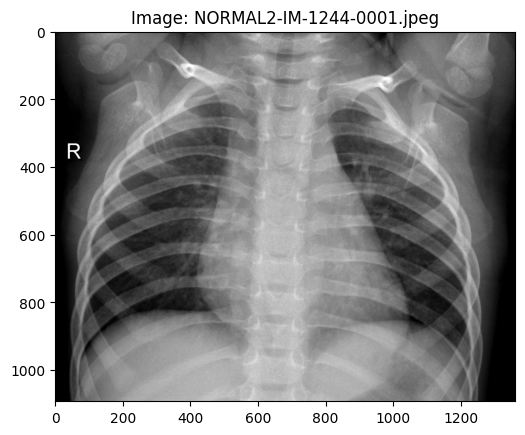

Shape of random image from ./data/train/NORMAL/NORMAL2-IM-1244-0001.jpeg is (1093, 1362, 3)


In [6]:

def plot_image(image_path, title=""):
    """
    Display an image using matplotlib and print its details.
    
    Parameters:
    image_path (str): The directory where the image is stored.
    title (str): The filename of the image to display.
    """
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
    plt.title(f"Image: {title}")
    plt.show()
    print(f"Shape of random image from {image_path} is {img.shape}")

random_dir = random.choice(['train_normal', 'train_pneumonia', 'test_normal', 'test_pneumonia'])
filelist = os.listdir(dir_paths[random_dir])
filelist_random = random.choice(filelist)
plotted_image = os.path.join(dir_paths[random_dir], filelist_random)
plot_image(plotted_image, filelist_random)

In [7]:
def avg_height_width(path):
    filelist = os.listdir(path)
    ht,wt=0,0
    for x in filelist:
        img_path = os.path.join(path,x )
        img=plt.imread(img_path)
        shape=img.shape
        ht += shape[0]
        wt += shape[1]
    print(f"Average height and width of images in {path} is {ht//100} and {wt//100} respectively, with aspect ratio {ht/wt}")
    return {'height': ht//100, 'width': wt//100, 'aspect ratio': ht/wt}


average_height_width_train = {
    "train":{
        'normal': avg_height_width(dir_paths['train_normal']),
        'pneumonia': avg_height_width(dir_paths['train_pneumonia'])
    },
    "test":{
        'normal': avg_height_width(dir_paths['test_normal']),
        'pneumonia': avg_height_width(dir_paths['test_pneumonia'])
    }
}

print(average_height_width_train)

avg_total_height = (average_height_width_train['train']['normal']['height'] + average_height_width_train['train']['pneumonia']['height'] + average_height_width_train['test']['normal']['height'] + average_height_width_train['test']['pneumonia']['height'])//4
avg_total_width = (average_height_width_train['train']['normal']['width'] + average_height_width_train['train']['pneumonia']['width'] + average_height_width_train['test']['normal']['width'] + average_height_width_train['test']['pneumonia']['width'])//4
avg_total_aspect_ratio = (average_height_width_train['train']['normal']['aspect ratio'] + average_height_width_train['train']['pneumonia']['aspect ratio'] + average_height_width_train['test']['normal']['aspect ratio'] + average_height_width_train['test']['pneumonia']['aspect ratio'])//4

print(f"Average height and width of images in total dataset is {avg_total_height} and {avg_total_width} respectively, with aspect ratio {avg_total_aspect_ratio}")

Average height and width of images in ./data/train/NORMAL is 18524 and 22364 respectively, with aspect ratio 0.8283278901392933
Average height and width of images in ./data/train/PNEUMONIA is 31969 and 46518 respectively, with aspect ratio 0.6872453983061451
Average height and width of images in ./data/test/NORMAL is 3203 and 4212 respectively, with aspect ratio 0.7604772225004807
Average height and width of images in ./data/test/PNEUMONIA is 2984 and 4449 respectively, with aspect ratio 0.6708224606166039
{'train': {'normal': {'height': 18524, 'width': 22364, 'aspect ratio': 0.8283278901392933}, 'pneumonia': {'height': 31969, 'width': 46518, 'aspect ratio': 0.6872453983061451}}, 'test': {'normal': {'height': 3203, 'width': 4212, 'aspect ratio': 0.7604772225004807}, 'pneumonia': {'height': 2984, 'width': 4449, 'aspect ratio': 0.6708224606166039}}}
Average height and width of images in total dataset is 14170.0 and 19385.75 respectively, with aspect ratio 0.7367182428906307


In [8]:
def resize_and_save_images(input_path, output_path, average_height=avg_total_height, average_width=avg_height_width):
    print(f"Resizing and saving images from {input_path} to {output_path} at {average_height}x{average_width}")
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    filelist = os.listdir(input_path)
    for filename in filelist:
        img_path = os.path.join(input_path, filename)
        with Image.open(img_path) as img:
            resized_img = img.resize((average_width, average_height))
            resized_img.save(os.path.join(output_path, filename))
    print(f"Processed {len(filelist)} images.")
    

resize_and_save_images(dir_paths['train_normal'], os.path.join(temp_dir_base, 'train/normal'))
resize_and_save_images(dir_paths['train_pneumonia'], os.path.join(temp_dir_base, 'train/pneumonia'))



TypeError: type function doesn't define __round__ method

In [46]:
# def resize_images(path, average_height=round(avg_total_height), average_width=round(avg_total_width)):
#     print(f"Resizing images in {path} to {average_height}x{average_width}")
#     resized_images = []
#     filelist = os.listdir(path)
#     for filename in filelist:
#         img_path = os.path.join(path, filename)
#         with Image.open(img_path) as img:
#             resized_img = img.resize((average_width, average_height))
#             resized_images.append((filename, resized_img)) 
#     # clear console
#     return resized_images

# reshaped_train = {
#     'normal': resize_images(dir_paths['train_normal']),
#     'pneumonia': resize_images(dir_paths['train_pneumonia'])
# }

# print(reshaped_train)

Resizing images in ./data/train/NORMAL to 14170x19386


Temporary directory created at: /tmp/tmptzh9qhx0


Saved 1341 images to /tmp/tmptzh9qhx0/train/normal
Saved 3875 images to /tmp/tmptzh9qhx0/train/pneumonia


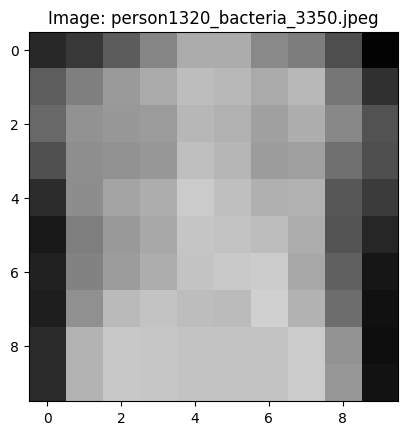

Shape of random image from /tmp/tmptzh9qhx0/train/pneumonia/person1320_bacteria_3350.jpeg is (10, 10, 3)


In [45]:
# def save_images(images, save_directory):
#     # if the directories already exist, delete them
#     if os.path.exists(save_directory):
#         for file in os.listdir(save_directory):
#             os.remove(os.path.join(save_directory, file))
#         os.rmdir(save_directory)
#     # create the directory
#     if not os.path.exists(save_directory):
#         os.makedirs(save_directory) 
#     #save the images
#     for filename, image in images:
#         save_path = os.path.join(save_directory, filename)
#         image.save(save_path)
#     print(f"Saved {len(images)} images to {save_directory}")
    
# print("Temporary directory created at:", temp_dir_base)
# save_images(reshaped_train['normal'], os.path.join(temp_dir_base, 'train/normal'))
# save_images(reshaped_train['pneumonia'], os.path.join(temp_dir_base, 'train/pneumonia'))

# random_dir = random.choice(['normal', 'pneumonia'])
# filelist = os.listdir(os.path.join(temp_dir_base, 'train', random_dir))
# filelist_random = random.choice(filelist)
# plotted_image = os.path.join(temp_dir_base, 'train', random_dir, filelist_random)
# plot_image(plotted_image, filelist_random)


In [1]:
# clean up the temporary directories
# delete all the files in the temp_dir_base
os.system(f"rm -r {temp_dir_base}")
print("Temporary directory deleted successfully")



NameError: name 'os' is not defined